In [138]:
%load_ext autoreload
%autoreload 2
import pathlib
import pandas as pd
import seaborn as sns
import numpy as np

from statsmodels.stats.multitest import multipletests

sns.set(font_scale=1.5, style='darkgrid')
pd.options.display.max_columns=999

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import utils as ut

In [61]:
factorsModel = ['trees', 'depth']

measuresNoIS = ['tp', 'tn', 'fp', 'fn', 'sensibility','specificity', 'precision', 
                'accuracy', 'F1', 'Gmean', 'wtdAcc','AreaROC', 'balancedAcc', 'mcc']

factorsNoIS = ['database']

cols_to_dedup_noIs = ['ands', 'database', 'k', 'type'] +factorsModel

ANDS = [2,4,6,8,10]

## curar información under sampling

In [75]:
path = pathlib.Path("data/data_under_sampling") 
results = pd.DataFrame()
files = []
for i in path.glob('**/*.csv'):
    i.name
    partial = pd.read_csv(i.absolute())
    dataset =  i.name.split('_')[2]
    print(i, dataset)
    partial['database' ] = dataset
    results = pd.concat([results, partial], ignore_index = True)


data/data_under_sampling/output_results_fraudk_randomSubSampling_reports.csv fraudk
data/data_under_sampling/output_results_pageblocks_randomSubSampling_reports.csv pageblocks


In [76]:
results[['wtdAcc', 'balancedAcc', 'mcc']] = results.apply(ut.compute_metrics , axis = 1)
results['type'] = results['type'].str.lower()


In [77]:
under_sampling_results = (results.groupby(factorsNoIS)
                .apply(lambda g : ut.get_best_for(g, 
                measuresNoIS, 
                measure_sort = 'Gmean', 
                factorsModel = factorsModel, 
                debug = False, 
                agg=False))
                .reset_index())


under_sampling_results['model_complexity'] =  under_sampling_results.trees*under_sampling_results.depth

In [78]:
dfs = []
for a in ANDS:
    df_partial = under_sampling_results.copy()
    df_partial['ands'] = a
    dfs.append(df_partial)
under_sampling_results = pd.concat(dfs, ignore_index=True)

In [79]:
under_sampling_results.to_csv("data/reportes_curados/under_sampling_results.csv", index = False)

Leer los resultados de IS y NO IS

In [82]:
IS_results = pd.read_csv("data/reportes_curados/IS_results.csv")
NO_IS_best = pd.read_csv("data/reportes_curados/NO_IS_best.csv")
under_sampling_results = pd.read_csv("data/reportes_curados/under_sampling_results.csv")

In [127]:
FACTORS =  ['database', 'Gmean', 'k', 'ands']
METRIC = 'Gmean'

get_no_factors = list(set(FACTORS) - {METRIC})
get_cond = lambda df : df.loc[df['type']=='test',FACTORS]

no_is_under_sampling = get_cond(under_sampling_results).merge(get_cond(NO_IS_best), on = get_no_factors, suffixes = ('_under_sampling', '_NO_IS'))

no_is_under_sampling = pd.melt(no_is_under_sampling, id_vars= get_no_factors)

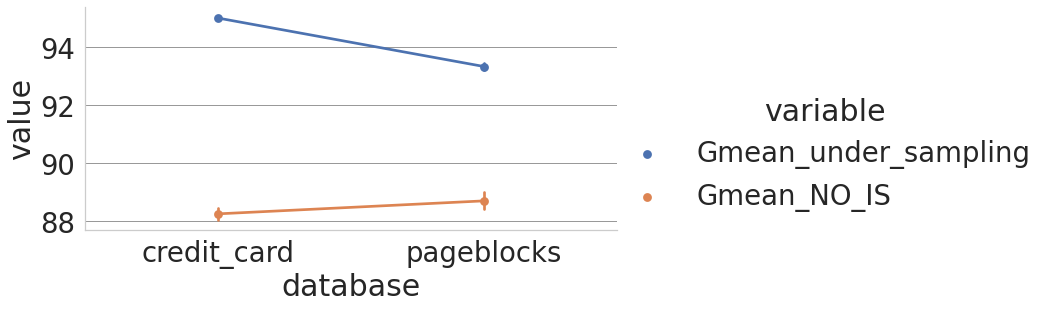

In [128]:
sns.catplot(data = no_is_under_sampling, hue='variable',y='value', x = 'database', kind = 'point', aspect =2)

In [102]:
under_sampling_results.groupby(['database'])['depth'].unique()

database
credit_card    [10]
pageblocks     [10]
Name: depth, dtype: object

In [87]:
db_map = {'fraudk': 'credit_card', 'p2p':'gateway_credit_card', 'pageblocks': 'pageblocks'}
is_map = {'entropy': 'entropy', 'boundaries':'drop3-boundaries', 'one': 'drop3-one'}
lsh_map = {'hyperplanes': 'RHF', 'projection':'DPF', 'hyperplanes-projection': 'RHF+DPF'}

In [88]:
under_sampling_results['database']= under_sampling_results.database.map(db_map)

reference credit_card (25, 2)
reference credit_card (25, 2)
reference credit_card (25, 2)
reference pageblocks (25, 2)
reference pageblocks (25, 2)
reference pageblocks (25, 2)
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/german/venv/udea/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1331/878153631.py", line 4, in <cell line: 4>
    g,_ = ut.plot_9_results(df_in = IS_results[IS_results.database!='gateway_credit_card'],
  File "/home/german/repos/results-analysis/utils.py", line 295, in plot_9_results
    g.set_titles(col_template="{col_name}", fontsize=40)
  File "/home/german/venv/udea/lib/python3.8/site-packages/seaborn/axisgrid.py", line 1027, in set_titles
    self.axes.flat[i].set_title(title, **kwargs)
  File "/home/german/venv/udea/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 169, in set_title
    title.update(kwargs)
  File "/home/german/venv/udea/lib/python3.8/site-packages/matplotlib/text.py", line 164, in update
    kwargs = cbook.normalize_kwargs(kwargs, Text)
  File "/home/german/venv/udea/lib/python3.8/site-pack

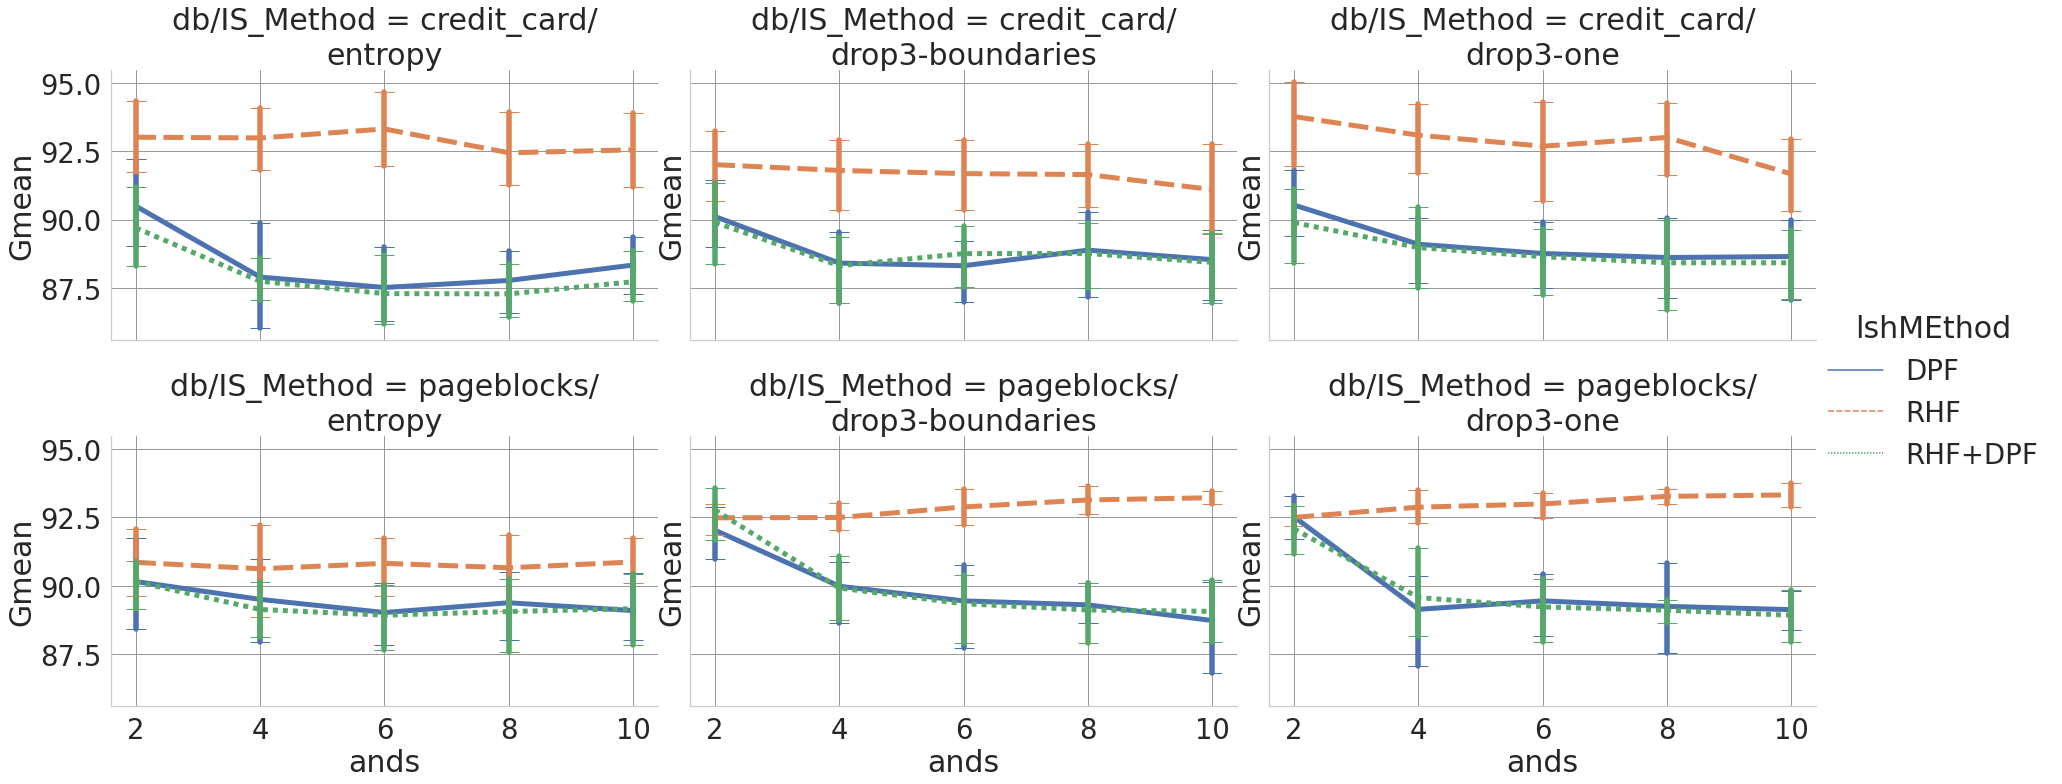

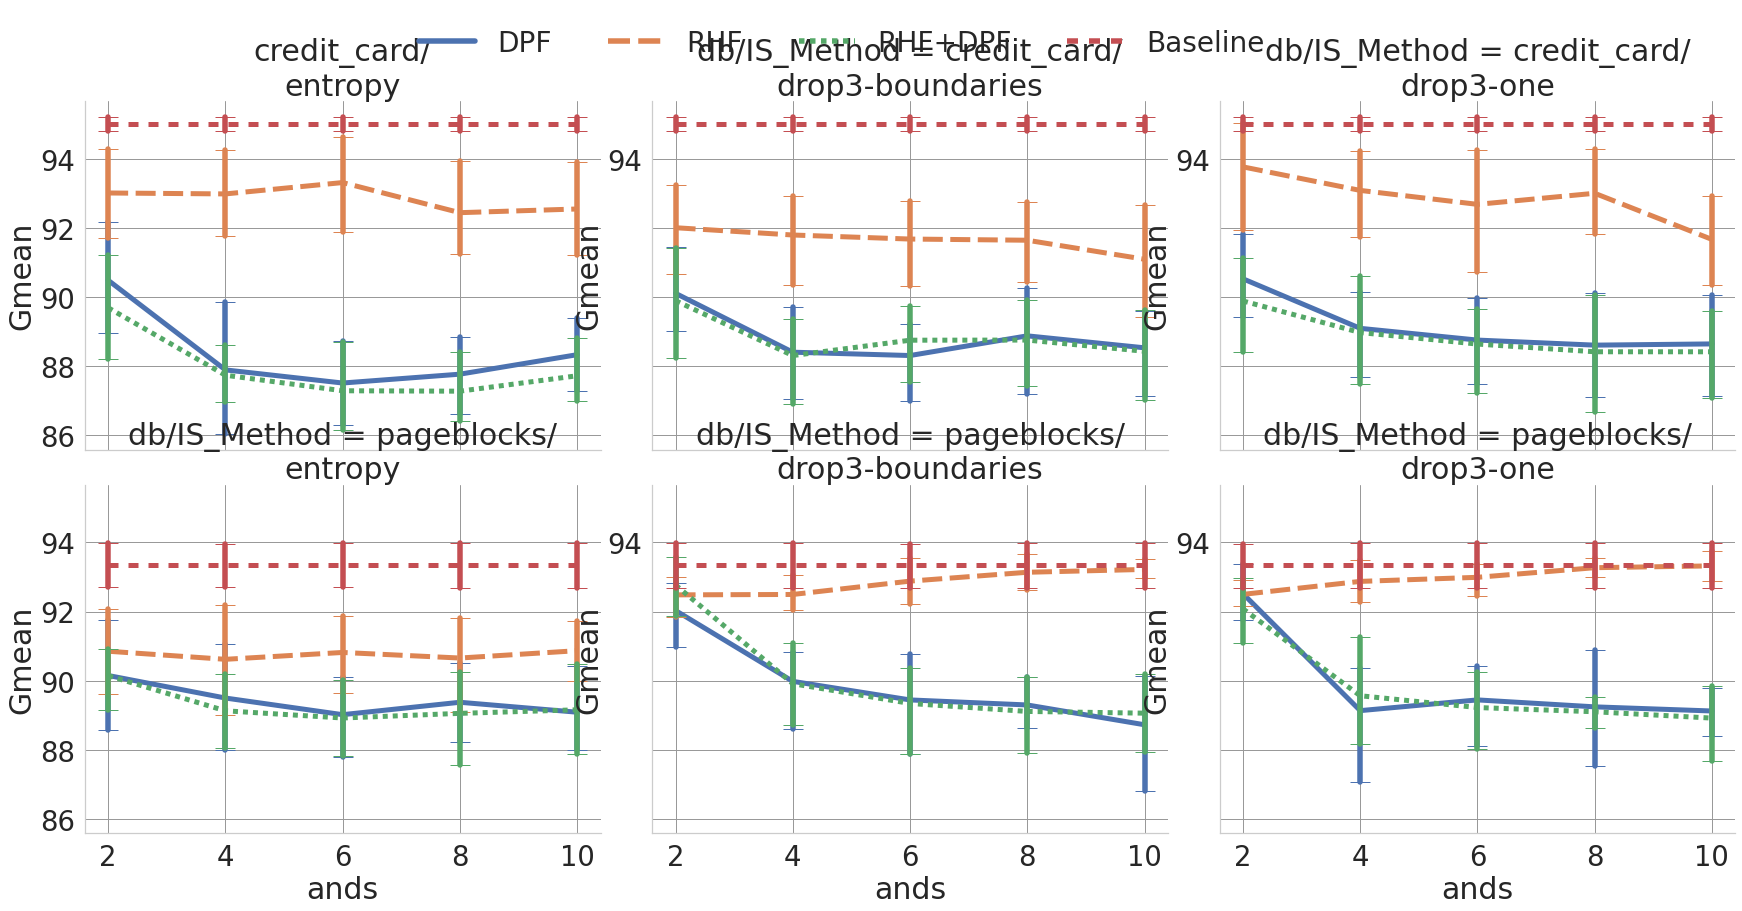

In [95]:
sns.set(font_scale=2.5, style='whitegrid',
        rc={'grid.color': '.6'})

g,_ = ut.plot_9_results(df_in = IS_results[IS_results.database!='gateway_credit_card'], 
df_reference = under_sampling_results, measure= 'Gmean', measure_for_best='Gmean', aspect =1.5, height=5.8)

Test estadisticos

In [126]:
from scipy.stats import wilcoxon

In [129]:
ref = under_sampling_results.drop_duplicates(["database", "k", "type"])
ref = ref.loc[(ref.type == 'test'), ['database', 'k', METRIC]].copy()

In [139]:
import itertools

df_toplot =  IS_results[IS_results.database!='gateway_credit_card']



ismet = df_toplot.one_class_method.unique()
lsh = df_toplot.lshMEthod.unique()
ands = df_toplot.ands.unique()

combinations = list(itertools.product(ismet, lsh, ands))

In [140]:
pairwise_comp = pd.DataFrame(columns = ['is_method', "lsh", "ands", "p", "conclusion", "statistic", "avg", "avg_ref","is_win"])
alpha = 0.05
for i,c in enumerate(combinations):
	is_m, lsh_f, a_f = c
	condition = ( (df_toplot.ands==a_f)
				& (df_toplot.one_class_method==is_m) 
				& (df_toplot.lshMEthod==lsh_f)
				& (df_toplot.type=="test") )

	first = df_toplot.loc[condition,   ['database', 'k', METRIC]].copy()
	#print ("shape is", first.shape)
	ref_adj = pd.merge(ref, first.drop(METRIC, axis = 1), on = ['database', 'k'])
	#print ("shape is", ref_adj.shape)
	stat, p = wilcoxon(ref_adj[METRIC], first[METRIC])
	avg_met = first[METRIC].mean()
	avg_ref = ref_adj[METRIC].mean()
	is_diff_dist = p <= alpha
	is_win = (avg_met>avg_ref )and (is_diff_dist)
	pairwise_comp.loc[i, :] = [is_m, lsh_f,a_f, p, is_diff_dist , stat, avg_met, avg_ref, is_win]

pairwise_comp= pairwise_comp.convert_dtypes()

In [144]:
conclusion_corr, p_corr, _, _ = multipletests(pairwise_comp.p, method = 'holm')
pairwise_comp['p_corr'] = p_corr
pairwise_comp['conclusion_corr'] = conclusion_corr
pairwise_comp['p_corr_win'] = pairwise_comp.apply(lambda r: r.p_corr if (r['avg']>r['avg_ref'])  else 100, axis = 1)

pairwise_comp['is_win_corr'] = (pairwise_comp['conclusion_corr']) &  (pairwise_comp['avg']>pairwise_comp['avg_ref']) 

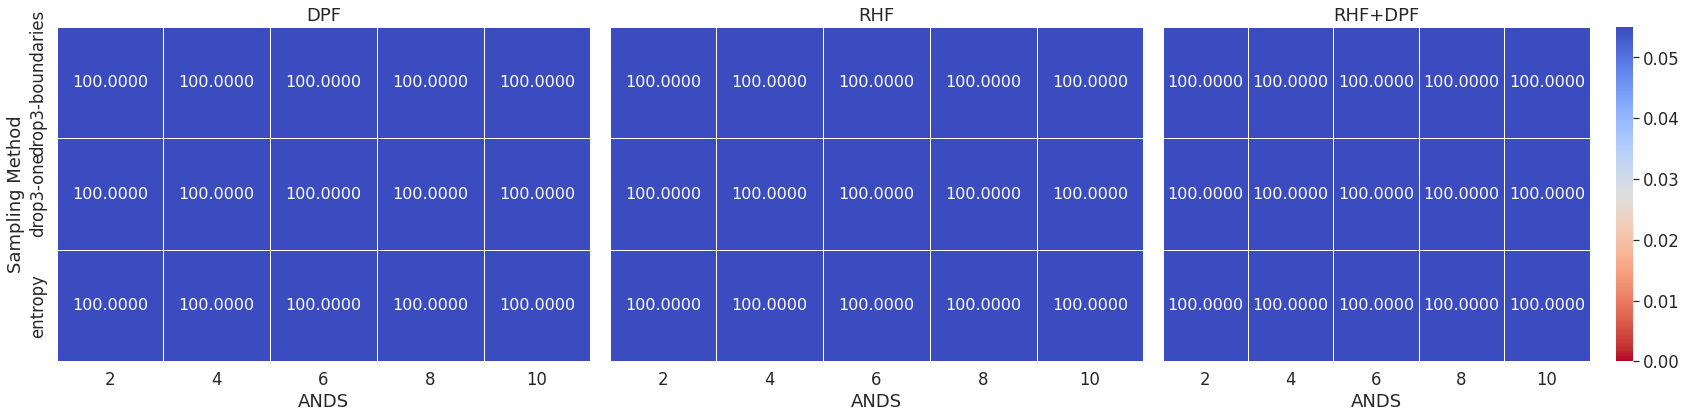

In [146]:
# results of pairwise compararion with reference
pairwise_comp['IS Method'] = pairwise_comp.is_method
pairwise_comp['ANDS'] = pairwise_comp.ands

fg = sns.FacetGrid(pairwise_comp, col='lsh', aspect = 1, height=8)
fg.map_dataframe(ut.draw_heatmap, 'ANDS', 'IS Method', 'p_corr_win', cmap = 'coolwarm_r', annot = True, vmin = 0.0, vmax=0.055,  linewidths=.5, fmt = '.4f', annot_kws = {'fontsize':16})
fg.fig.subplots_adjust(top=0.7) # adjust the Figure in rp

fg.set_titles(col_template="{col_name}")
fg.set_ylabels("Sampling Method")